<a href="https://colab.research.google.com/github/scpepper69/ml-learning-materials/blob/master/TensorFlow_Keras_ImageClassificatioin_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI・機械学習 勉強会 #1
## - 多層パーセプトロンおよび畳み込みニューラルネットワークによる画像分類 -


※ まえがき

このjupyter notebookは、東京大学 松尾研究所が公開している[DL4USコンテンツ](https://weblab.t.u-tokyo.ac.jp/dl4us/)を学習する中で、Deep Learningの前提知識が無い方や、数学が苦手な方においては、理論の理解が追い付かない部分があると感じ、トライ＆エラーによる実践を行うことがより理解を深めることができると考えて作成したものです。

数式や理論を省略しているため、これらも含めて詳しく理解するには、[DL4USコンテンツ](https://weblab.t.u-tokyo.ac.jp/dl4us/)の1章および2章を合わせて参照すると良いかと思います。

## 目次

  
1.1.   概要

1.2.   実装プロセス

1.   環境準備
2.   データの準備
3.   モデル構築
4.   モデルの学習
5.   モデルによる予測
5.   中間層データの可視化
5.   モデルのファイル出力









---



##1.1 概要
TensorFlow + Kerasによる実装を通じて基本的なDeep Learningの考え方や実装方法を学習します。

また、画像分類における多層パーセプトロン(MLP)と畳込みニューラルネットワーク(CNN)での比較を行い、モデル構造の違いとチューニングパラメータについて理解を深めます。

ソースコードはPython3を前提に書いてあります。また、特にCIFAR10においては学習に時間がかかるため、Google ColabではGPUランタイムを使ってください。




---



## 1.2 実装プロセス

ここでは、画像分類をMLP(Multi Layer Perceptron)とCNN(Convolutional Neural Network)の2つモデルにいて、教師あり学習モデルの実装およびモデル構造、学習結果の比較をしてみます。

実装に使用する題材は、MNIST(手書き数字画像)と、CIFAR10(乗り物や動物などの画像)の2種類とします。


参考：https://keras.io/ja/datasets/

### 1.2.1 環境準備

プログラムを動かすにあたって、モデルおよびデータセットを指定してください。

<モデル構造>
* 多層パーセプトロン(MLP)
* 畳込みニューラルネットワーク(CNN)

<データセット>
* MNIST：手書き数字(グレースケール)
* CIFAR10：乗り物や動物の画像(カラー)

以下の順序で動かしてみると良いかと思います。

1. MNISTデータセットのMLP
2. MNISTデータセットのCNN
3. CIFAR10データセットのMLP
4. CIFAR10データセットのCNN

また、このjupyter notebookはTensorFlow 1.13.1を前提に実装しています。2019/6/14時点でバージョンが変更(1.14)となったため、ダウングレードしておきます。

※その他ライブラリが変更になり、動作しなくなる可能性もありますが、Google Colabの仕様次第のため、都度チューニングして使ってください。

In [1]:
# ライブラリのバージョン調整
# 2019/6/14時点でデフォルトのTensorflowバージョンが変わった模様
!pip install tensorflow-estimator==1.13.0 tensorflow-gpu==1.13.1

# モデル構造を指定します (MLP or CNN)
model_structure="CNN"
# データセットを指定します (MNIST or CIFAR10)
data_set="CIFAR10"

     |████████████████████████████████| 368kB 3.4MB/s 
     |████████████████████████████████| 345.2MB 80kB/s 
ERROR: tensorflow 1.14.0rc1 has requirement tensorflow-estimator<1.15.0rc0,>=1.14.0rc0, but you'll have tensorflow-estimator 1.13.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.14.0rc1
    Uninstalling tensorflow-estimator-1.14.0rc1:
      Successfully uninstalled tensorflow-estimator-1.14.0rc1


Google Colabratoryは、ランタイムが初期化されるとデータも失われます。

学習した中のチェックポイントが学習済みモデルを再利用できるよう、Google Driveをマウントし、ここに出力できるようしておきましょう。

In [2]:
import os, shutil
from google.colab import drive
drive.mount('/content/drive/')
gdrive_base='/content/drive/My Drive/Colab Notebooks/'

# TensorBorad用ログ
log_dir=gdrive_base+'ImageClassification/logs/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# チェックポイントおよび学習済みモデルファイル
model_dir=gdrive_base+'ImageClassification/model/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


### 1.2.2 データの準備
教師あり学習を行う場合、学習させるデータを用意する必要があります。

MNISTおよびCIFAR10はKerasにて提供されていますので、ここではこちらを使います。

なお、データの収集は非常に地味かつ大変な作業ですが、このデータの事前準備が非常に重要であり、"使える"データの量や種類が、モデルの精度に大きく関わってきます。

今回は用意されたものを使いますが、自分で集めたデータセットにて学習させることも非常に良い経験となるため、ぜひご自身でもトライしてみてください。
         
今回扱うMNISTおよびCIFAR10のデータ構造は下記となっています。

* x：画像(MNIST：28×28x1、CIFAR10：32x32x1) ※縦x横xグレー(1)orカラー(3)
* y：正解のラベル(xの画像が表す意味)

また、これらデータセットは学習用と評価用に最初から分割されています。

* (x_train, y_train):モデルの学習用
* (x_test, y_test):モデルの評価用

Deep Learningでは学習データでの認識精度が高くても意味がありません。

学習時にはなかった未知のデータについても正しく認識させること(これを汎化性能といいます)が目的であり、これが精度の高い学習モデルと言えます。

In [3]:
# Kerasにて用意されているデータセットをダウンロードします
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import cifar10

# MNIST
if data_set == "MNIST":
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    img_size,img_color=28,1
# CIFAR10
else:
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    img_size,img_color=32,3

170500096/170498071 [==============================] - 2s 0us/step


ダウンロードした画像と画像に対応したラベルを表示してみます。

画像表示には、matplotlibライブラリを用います。これはPythonにてグラフ表示によく使われるライブラリなので、使用方法は覚えておくと良いです。

参考：https://matplotlib.org/api/pyplot_api.html


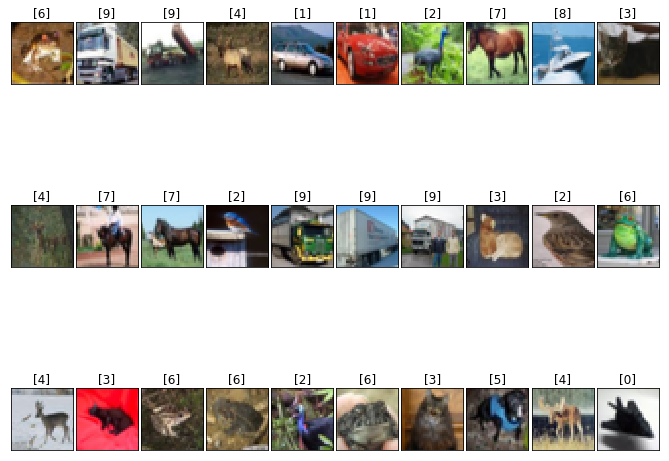

In [4]:
#jupyter notebook用マジックコマンド
%matplotlib inline 
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)

# 各MNIST画像の上に（タイトルとして）対応するラベルを表示
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.set_title(str(y_train[i]))
    ax.imshow(x_train[i], cmap='gray')

これから実施するのは、MINISTにしても、CIFAR10にしても、いわゆる10クラス分類の問題です。（分類すべき対象のことを**クラス**と呼びます）

画像分類を行うにあたって以下2点、前提として理解しておく必要があります。

1.   ラベルの意味

        MNISTにおいては、ラベルの値が数字としての意味と一致しているように見えますが、これはただの偶然でしかなく、あくまで、ラベルの値はクラスのインデックスに過ぎない数値ということです。

        CIFAR10で試してみるとわかりますが、飛行機の画像のラベルは"0"であってairplaneという意味を持っているわけではありません。

        要するに、Deep Learningとして理解している(させている)わけではないということです。

        後ほど実装内にも出てきますが、各インデックスの意味づけは人がプログラム内でつけることなります。

        画像分類の問題に限らず、現在のDeep Learningにおいては、1次的な結果を学習させ人間を超える精度を発揮することは可能ですが、2次的情報を付加するのはあくまで人間であり、その情報を理解し拡張することはまだできないと認識しておいてください。


2.   ラベルの表現

        もう一つ、インデックスなので、データとしては数字で表現されてしまいますが、Deep Learningを行う上で、これを数字としての意味を持って扱ってもらっては困るため、全クラス中のどのクラスに該当するかという表現に置き換える必要があります。

        これを**one-hot表現**と呼んでいます。

        * ラベル 0 = airplane -> (one-hot表現) -> [1,0,0,0,0,0,0,0,0,0]  ※10要素の配列の0番目に該当
        * ラベル 1 = car -> (one-hot表現) -> [0,1,0,0,0,0,0,0,0,0] ※10要素の配列の1番目に該当

    Kerasには、この**one-hot表現**に変換してくれる関数(keras.utils.to_categorical)が用意されています。
    

In [0]:
from tensorflow.keras.utils import to_categorical
import numpy as np

# ラベルデータをone-hot表現へ変換 (10クラス)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

MLPでは、画像上の位置情報を意識せず、１次元配列として次の層に全結合させていきます。

一方、CNNは画像の位置情報を保持した３次元配列のまま、ConvolutionおよびPoolingすることで特徴量を抽出します。

そのため、学習および推論する際のINPUTデータ形式は、MLPは１次元配列、CNNは３次元配列となります。

In [0]:
# 画像データの形式をMLPおよびCNNに適した形に修正
# for CNN 
if model_structure=="CNN":
    x_train = x_train.reshape(-1, img_size, img_size, img_color).astype(np.float32)
    x_test = x_test.reshape(-1, img_size, img_size, img_color).astype(np.float32)
    input_shape = (img_size, img_size, img_color)
# for MLP        
else:
    # 入力画像を行列(28x28)からベクトル(長さ784)に変換
    x_train = x_train.reshape(-1, img_size*img_size*img_color)
    x_test = x_test.reshape(-1, img_size*img_size*img_color)
    input_shape = (img_size*img_size*img_color,)


### 1.2.3 モデル構築

これから、学習モデルを構築します。

モデルの構築は、モデルの「容器」としてSquential()を実施したのち、その中に順にレイヤーを追加していく流れになります。

* [Sequential](https://keras.io/ja/models/sequential/)


In [0]:
# モデル構築用ライブラリをインポート
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten

# CNNモデル用ライブラリ
from tensorflow.python.keras.layers import Conv2D, Convolution2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D,Input
from tensorflow.python.keras import initializers
from tensorflow.keras.applications.vgg16 import VGG16

# モデルの「容器」を作成
model = Sequential()

これから、モデル構造を定義していきます。ここでは、モデルの切り替えが容易にできるように、ここではモデル構造ごとにfunctionを用意しておきます。

なお、Kerasでは最初にaddするレイヤにてInput_shapeを定義してやる必要があります。

下記実装においては、入出力を除いた中間層について、MLPは全結合2層、CNNは畳込み2層＋全結合1層としています。

各レイヤーのパラメータ等についてはKerasのドキュメントを参照してください。

* [Dense/Actication/Dropout](https://keras.io/ja/layers/core/)
* [Conv2D](https://keras.io/ja/layers/convolutional/)
* [MaxPooling](https://keras.io/ja/layers/pooling/)
* [Batch Normalization](https://keras.io/ja/layers/normalization/)


MLPにおいては、3つの異なる活性化関数(Activation)のfunctionを用意しています。

また、CNNにおいては、Dropoutの有無とBatch Nrmalizationを実装したfunctionを用意しています。

特にCIFAR10の分類においては、このままの実装では高い精度は得られないはずです。

それぞれのモデルの比較とともに、層の深さやレイヤーの構成、レイヤーごとのパラメータなどを自由にいじってみて、どのような変化が起こるか試してみましょう。


In [0]:
# MLPモデル
def mlp_relu_model():
    model.add(Dense(units=256, input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Dense(units=100))
    model.add(Activation('relu'))
    model.add(Dense(units=10))
    model.add(Activation('softmax'))

    return model

def mlp_sigmoid_model():
    model.add(Dense(units=256, input_shape=input_shape))
    model.add(Activation('sigmoid'))
    model.add(Dense(units=100))
    model.add(Activation('sigmoid'))
    model.add(Dense(units=10))
    model.add(Activation('softmax'))

    return model

def mlp_tanh_model():
    model.add(Dense(units=256, input_shape=input_shape))
    model.add(Activation('tanh'))
    model.add(Dense(units=100))
    model.add(Activation('tanh'))
    model.add(Dense(units=10))
    model.add(Activation('softmax'))

    return model


In [0]:
# CNNモデル
def cnn_model():
    model.add(Conv2D(32, (3, 3), kernel_initializer=initializers.TruncatedNormal(stddev=0.1), bias_initializer=initializers.Zeros(), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), kernel_initializer=initializers.TruncatedNormal(stddev=0.1), bias_initializer=initializers.Zeros()))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, kernel_initializer=initializers.TruncatedNormal(stddev=0.1), bias_initializer=initializers.Zeros()))
    model.add(Activation('relu'))
    model.add(Dense(units=10))
    model.add(Activation('softmax'))

    return model

# CNNモデル w/Dropout
def cnn_w_dropout():
    model.add(Conv2D(32, (3, 3), kernel_initializer=initializers.TruncatedNormal(stddev=0.1), bias_initializer=initializers.Zeros(), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), kernel_initializer=initializers.TruncatedNormal(stddev=0.1), bias_initializer=initializers.Zeros()))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(256, kernel_initializer=initializers.TruncatedNormal(stddev=0.1), bias_initializer=initializers.Zeros()))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=10))
    model.add(Activation('softmax'))

    return model
    
# CNNモデル w/Batch Normalization
def cnn_w_batchnorm():
    model.add(Conv2D(32, (3, 3), kernel_initializer=initializers.TruncatedNormal(stddev=0.1), bias_initializer=initializers.Zeros(), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), kernel_initializer=initializers.TruncatedNormal(stddev=0.1), bias_initializer=initializers.Zeros()))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), kernel_initializer=initializers.TruncatedNormal(stddev=0.1), bias_initializer=initializers.Zeros(), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), kernel_initializer=initializers.TruncatedNormal(stddev=0.1), bias_initializer=initializers.Zeros()))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, kernel_initializer=initializers.TruncatedNormal(stddev=0.1), bias_initializer=initializers.Zeros()))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dense(units=10))
    model.add(Activation('softmax'))

    return model
    
# CNNモデル VGG16
def cnn_vgg16():
    input_tensor = Input(shape=(img_size, img_size, img_color))
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)    
    
    add_model = Sequential()
    add_model.add(Flatten())
    add_model.add(Dense(256, kernel_initializer=initializers.TruncatedNormal(stddev=0.1), bias_initializer=initializers.Zeros()))
    add_model.add(Activation('relu'))
    add_model.add(BatchNormalization())
    add_model.add(Dense(units=10))
    add_model.add(Activation('softmax'))
    
    vgg16_model = Model(inputs=vgg16.input, outputs=add_model(vgg16.output))

    #fix weights VGG16 layers
    for layer in vgg16.layers:
        layer.trainable = False
        
    return vgg16_model

それでは、任意のモデルを選び、構築してみましょう。

In [10]:
# model構築
if model_structure=="CNN":
#    model=cnn_model()
#    model=cnn_w_dropout()
    model=cnn_w_batchnorm()
#    model = cnn_vgg16()
else:
    mlp_relu_model()
#    model=mlp_sigmoid_model()
#    model=mlp_tanh_model()


Instructions for updating:
Colocations handled automatically by placer.


先ほど定義したモデルを視覚的に理解できるよう、モデル構造を図示してみます。

図示するツールはconvert-drawerというツールを用います。

convert-drawerのオリジナルのgithubはココですが、MLPやDropoutやBatch Normalizationへも対応できるよう、修正を加えています。

また、ついでにに各レイヤーの定義情報を参考として出力してみます。この定義情報は各レイヤーのadd時にパラメータとして付与できるものたちです。

デフォルトとして明示していないものがどれだけあり、実際はどのようなパラメータで動いているか見てみてください。

Cloning into 'convert_drawer'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 299 (delta 47), reused 50 (delta 22), pack-reused 219
Receiving objects: 100% (299/299), 1.57 MiB | 12.12 MiB/s, done.
Resolving deltas: 100% (177/177), done.


Using TensorFlow backend.


Conv2D {'name': 'conv2d', 'trainable': True, 'batch_input_shape': (None, 32, 32, 3), 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'TruncatedNormal', 'config': {'mean': 0.0, 'stddev': 0.1, 'seed': None, 'dtype': 'float32'}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
Activation {'name': 'activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}
Conv2D {'name': 'conv2d_1', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 

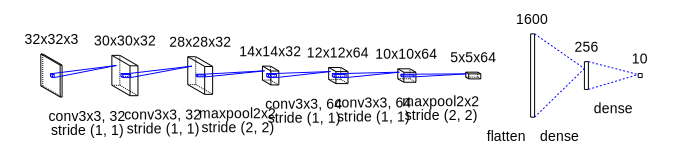

In [11]:
!git clone https://github.com/scpepper69/convnet-drawer.git convert_drawer
import sys
sys.path.append('./convert_drawer/')
from keras_util import convert_drawer_model
from keras_models import AlexNet
from matplotlib_util import save_model_to_file
from IPython.display import *

# get Keras sequential model
#keras_sequential_model = AlexNet.get_model()
draw_model = convert_drawer_model(model)

# save as svg file
draw_model.save_fig(f'{model_dir}{model_structure}_{data_set}_model_structure.svg')
display_svg(SVG(f'{model_dir}{model_structure}_{data_set}_model_structure.svg'))

学習の開始にあたり、最後にcompile関数でコンパイルを行います。

compile関数でも、学習にあたって以下のパラメータを指定する必要があります。

* optimizer（最適化手法）
* loss（損失関数）
* metrics（評価関数（任意））

以下サンプルコードでは、現在Kerasで利用できるoptimizerを並べてみました。こちらもそれぞれどのような結果になるか比較してみるといいでしょう。

In [0]:
from tensorflow.keras import optimizers
from tensorflow.keras import losses
# モデルの学習方法について指定しておく
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.001, momentum=0.9), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=0.001), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adagrad(lr=0.001), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adadelta(lr=0.001), metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adamax(lr=0.001), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.Nadam(lr=0.001), metrics=['accuracy'])


早速学習開始と行きたいところですが、学習の途中結果を記録する(Checkpoint)ことと、TensorBoard向けのログ情報を取得できるようにしておきましょう。

モデル構造や結果等の視覚化することで、何がどのように動いているのか、理解の手助けとなります。

このjupyter notebook上でも可視化ロジックを組み込んでいますが、通常のモデル開発においては、TensorBoardを用いるほうがスマートでしょう。


TensorBoardでも参照できるよう、設定を組み込んでおきます。

In [0]:
# TensorBoardでの可視化のため、出力先の設定
from tensorflow.keras import callbacks

tb_cb = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,write_images=1)

チェックポイントを生成しておくことで、中断した学習の再開や、チェックポイントを利用した静的モデルの出力を行うことができます。

In [0]:
# チェックポイント出力先
RUN = RUN + 1 if 'RUN' in locals() else 1
checkpoint_path = model_dir + f'run{RUN}/' + model_structure + "_" + data_set + "_cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# チェックポイントコールバックを作る
cp_cb = callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1, period=5)

学習の実行の前に、モデルのサマリ情報を確認してみましょう。

In [15]:
# モデルのサマリ情報の表示
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
__________

学習途上のチェックポイントから再開させることもできます。

load_weights関数にてチェックポイントファイルから重みをロードします。

In [0]:
# チェックポイントから学習済みパラメータを復元
#model.load_weights(f'{model_dir}run1/{model_structure}_{data_set}_cp-0010.ckpt')

### 1.2.4 モデルの学習

ようやく学習に入ります。学習処理はfit関数もしくはfit_generatorの2種類ありますが、ここではfit関数を使います。

ここでは以下の引数を与えます。

* x_train：学習に使用する画像データ
* y_train：学習に使用するラベルデータ(one-hot表現)
* batch_size：学習中のパラメータ更新を1回行うにあたって用いるサンプル数（ミニバッチのサイズ）
* epochs：学習のエポック数
* verbose：学習のログを出力するか（0:しない、1：バーで出力、2:エポックごとに出力）
* validation_data：検証用データ
* callbacks：訓練中のモデルの挙動を監視できるcallback関数を指定できます

fit関数にはこれ以外にもパラメータを持っています。

* [fit](https://keras.io/ja/models/model/#fit)


In [17]:
# epoch数を指定
epochs=10

# batchサイズを指定
batch_size=1000

# 学習の実行
result = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,callbacks=[tb_cb, cp_cb], validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
50000/50000 [==============================] - 57s 1ms/sample - loss: 1.8524 - acc: 0.3691 - val_loss: 5.2797 - val_acc: 0.2903
Epoch 2/10
50000/50000 [==============================] - 53s 1ms/sample - loss: 1.3925 - acc: 0.5128 - val_loss: 2.3113 - val_acc: 0.4033
Epoch 3/10
50000/50000 [==============================] - 52s 1ms/sample - loss: 1.2361 - acc: 0.5671 - val_loss: 1.6563 - val_acc: 0.4627
Epoch 4/10
50000/50000 [==============================] - 53s 1ms/sample - loss: 1.1300 - acc: 0.6072 - val_loss: 1.3236 - val_acc: 0.5404
Epoch 5/10
49000/50000 [============================>.] - ETA: 0s - loss: 1.0471 - acc: 0.6363
Epoch 00005: saving model to /content/drive/My Drive/Colab Notebooks/ImageClassification/model/run1/CNN_CIFAR10_cp-0005.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage ch

学習結果の評価については、evaluate関数にて得ることができます。

主な引数は次の通りです。

* x：評価に使用する入力データ
* y：評価に使用する出力データ
* batch_size：1回の評価を行うにあたって用いるサンプル数
* verbose：評価のログを出力するか（0:しない、1：する(デフォルト)）

基本的には、損失(Loss)は低ければ低いほうが、評価(Accuracy)は高ければ高いほうが良いです。

Accuracyはモデルの精度そのもの、Lossは学習が効率よく行われているかを示す指標で、Lossが高いまま収束していかない＝効率が良くなく、モデル構造やパラメータ改善の余地あり、という感覚でよいかと思います。


In [18]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.0525602535247802
Test accuracy: 0.6366


epochごとのAccuracyおよびLossの遷移をグラフ化してみましょう。

fit関数のreturnから、データを取得することができます。

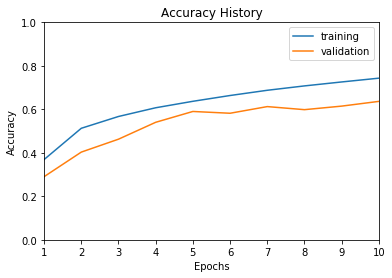

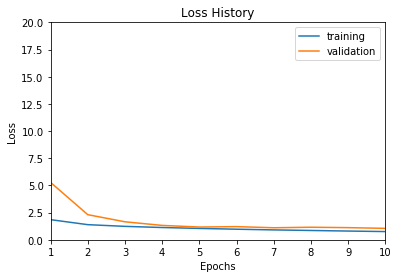

<Figure size 432x288 with 0 Axes>

In [19]:
result.history.keys() # ヒストリデータのラベルを見てみる
plt.plot(range(1, epochs+1), result.history['acc'], label="training")
plt.plot(range(1, epochs+1), result.history['val_acc'], label="validation")
plt.title('Accuracy History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xlim([1,epochs])
plt.ylim([0,1])
plt.show()
plt.savefig(model_structure+'_'+data_set+'_'+'acc.png')

plt.plot(range(1, epochs+1), result.history['loss'], label="training")
plt.plot(range(1, epochs+1), result.history['val_loss'], label="validation")
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xlim([1,epochs])
plt.ylim([0,20])
plt.show()
plt.savefig(model_structure+'_'+data_set+'_'+'loss.png')

### 1.2.5 モデルによる予測

精度だけ見ても面白くないので、検証用データの予測結果を見てみましょう。

Sequential.predict関数によって予測を行うことができます。

主な引数は次の通りです。

* x_test：予測に使用する入力データ
* batch_size：まとめて1度に予測を行うサンプル数
* verbose：評価のログを出力するか（0:しない(デフォルト)、1：する）

In [20]:
classes = model.predict(x_test, batch_size=128, verbose=1)

10000/10000 [==============================] - 0s 48us/sample


上記コマンドで検証用データ10000件の予測を実施しています。

どのような結果が得られているかイメージしやすくするために、画像を1枚抽出して、その結果を実際に見てみます。

なお、モデル構築の際に、いずれのモデルにおいても、出力層をDense(10)、Activation('softmax')としていました。

これは、10クラス(Dense(10))に、それぞれの確からしさを出力(Activation('softmax'))する、という意味になります。

softmaxでは、すべてのクラスの出力値の合計が1になります。そのため、この値が確からしさそのものを指し、最も値の大きいラベルが推論結果として採用することとなります。

なお、前述(1.2.2)にてラベルの意味づけに言及していましたが、本サンプルでは、ここでラベルの数値をラベルの意味に変換させています。

クラスごとの確からしさ(%)：[ 0.  0. 16.  4. 23. 11.  3. 43.  1.  0.]
推論結果：horse


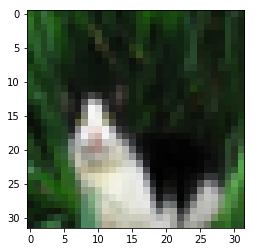

In [21]:
# データセットの推論結果と元画像を確認
# test_numを0～9999で指定してください
%matplotlib inline
test_num=1112
test_img = np.squeeze(x_test[test_num])
if not model_structure=="CNN":
    test_img = np.squeeze(test_img.reshape(img_size, img_size, img_color).astype(np.float32))

if data_set=="MNIST":
    labels = np.array([0,1,2,3,4,5,6,7,8,9])
else:
    labels = np.array([
        'airplane',
        'automobile',
        'bird',
        'cat',
        'deer',
        'dog',
        'frog',
        'horse',
        'ship',
        'truck'])

print("クラスごとの確からしさ(%)："+str(np.round(classes[test_num],decimals=2)*100))

print("推論結果："+str(labels[classes[test_num].argmax()]))
plt.imshow(test_img.astype(np.int),'gray')
plt.show()

正しく予測されていたでしょうか？

さらに進んで、検証用データにも存在しない画像で推論させてみましょう。

手書き画像(MNISTの場合)や、Web検索で画像を取得し、Google Colabにアップロードしてみましょう。

私が用意したサンプルデータも用意しておきます。

In [22]:
# サンプルデータのダウンロード
!wget https://raw.githubusercontent.com/scpepper69/ml-learning-materials/master/sample/images001.zip
!unzip images001.zip -d sample

--2019-06-19 08:47:36--  https://raw.githubusercontent.com/scpepper69/ml-learning-materials/master/sample/images001.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1230178 (1.2M) [application/zip]
Saving to: ‘images001.zip’

images001.zip       100%[===================>]   1.17M  --.-KB/s    in 0.07s   

2019-06-19 08:47:36 (16.8 MB/s) - ‘images001.zip’ saved [1230178/1230178]

Archive:  images001.zip
  inflating: sample/airplane001.png  
  inflating: sample/car001.png       
  inflating: sample/eight001.png     
  inflating: sample/five001.png      
  inflating: sample/four001.png      
  inflating: sample/nine001.png      
  inflating: sample/one001.png       
  inflating: sample/seven001.png     
  inflating: sample/six001.png       
  inflating: sample/th

ファイルをアップロードし終えたら、ファイル名を指定して推論してみましょう。

img_path変数にアップロードしたファイル名を指定し、実行してみてください。

こちらも正しい結果が得られたでしょうか。

3072
1/1 [==============================] - 0s 12ms/sample
クラスごとの確からしさ(%)：[[ 0. 98.  0.  0.  0.  0.  0.  0.  2.  0.]]
推論結果：automobile


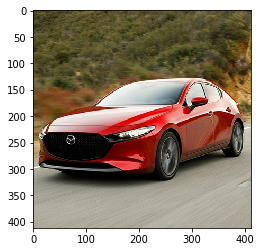

In [23]:
import cv2
    
# Google Colabにファイルをアップロード
# アップロードしたファイルを指定
img_path="./sample/car001.png"

if data_set=="MNIST":
    img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    img = 255 - img #白黒反転
    plt.imshow(img, 'gray')
else:
    img = cv2.imread(img_path,cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
    plt.imshow(img)

    
img = cv2.resize(img, dsize=(img_size,img_size)) # 28 x 28にサイズ変更
img = img.astype(np.float32)
print(img.size)

if model_structure=="CNN":
    img = img.reshape(1, img_size, img_size ,img_color) # 2次元から4次元に変換
else:    
    img = img.reshape(1, img_size*img_size*img_color).astype(np.float32)

pred = model.predict(img,verbose=1)

# 推論処理
print("クラスごとの確からしさ(%)："+str(np.round(pred,decimals=2)*100))
print("推論結果："+str(labels[pred.argmax()]))

予測精度の最終確認として、Confusion Matrixを表示してみます。

X軸とY軸が一致する箇所に集中していれば(要するに左上から右下に斜めに赤くなっている)、精度の良いモデルと言えるでしょう。

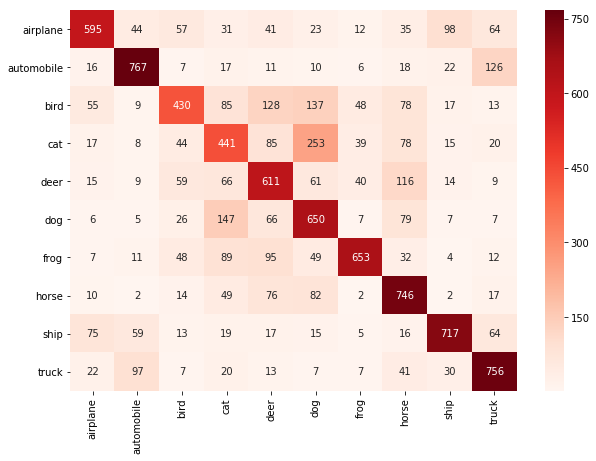

In [24]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#print(classification_report(np.argmax(y_test, 1), np.argmax(classes, 1)))
#print(confusion_matrix(np.argmax(y_test, 1), np.argmax(classes, 1)))

cmatrix = confusion_matrix(np.argmax(y_test, 1), np.argmax(classes, 1))
cmatrix_plt = pd.DataFrame(cmatrix, index=labels, columns=labels)

plt.figure(figsize = (10,7))
sns.heatmap(cmatrix_plt, annot=True, cmap="Reds", fmt="d")
plt.show()

### 1.2.6 中間層データの可視化

ここまでで、データを準備し、モデルを構築し、学習、推論させることができました。

どのように実装し、どのように使うのか、簡単にイメージすることができたのではないでしょうか。

この項では、モデルがどのように動きているか理解を深めるために、中間層のデータを見てみます。

ただ、MLPでは1次元に変換してしまっているので、見てもよくわからないかもしれませんが。

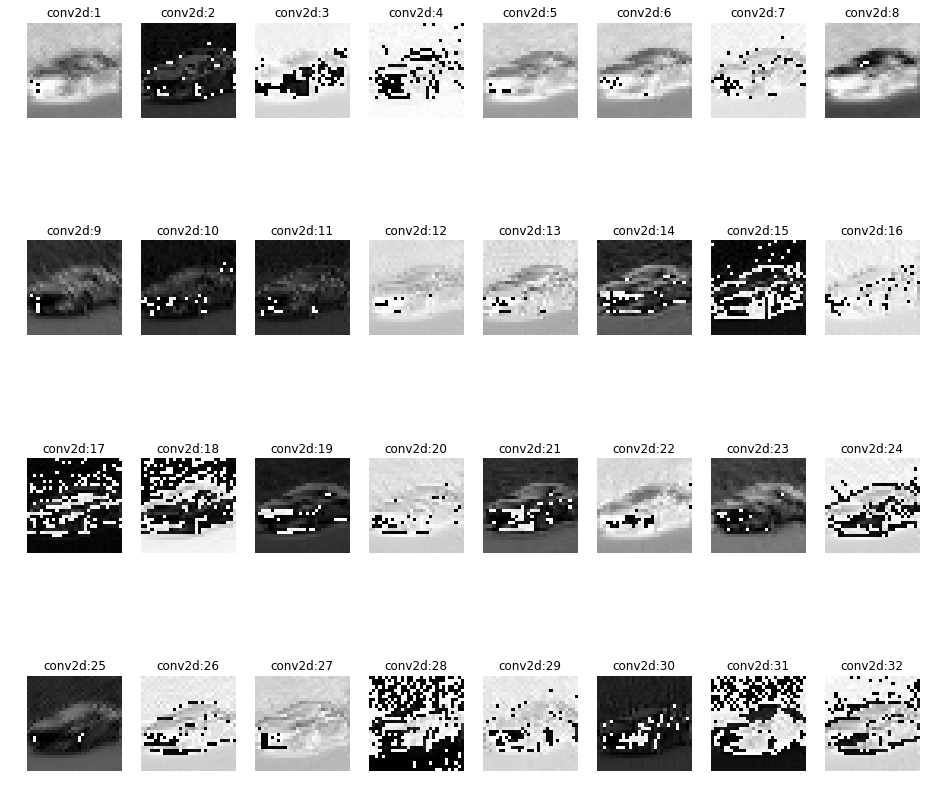

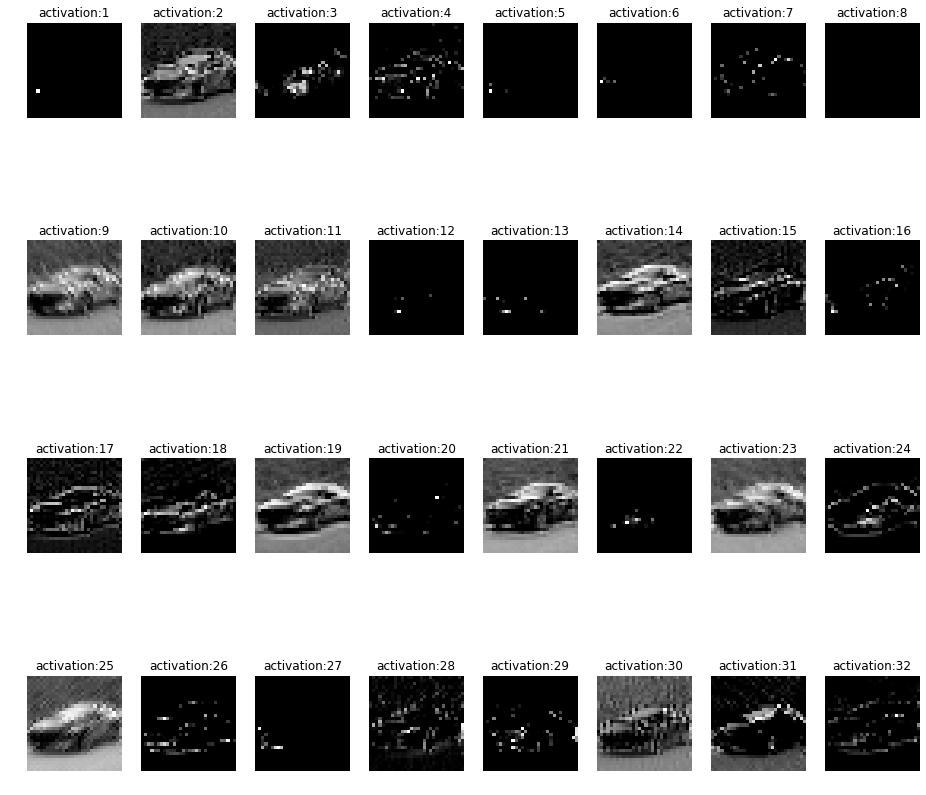

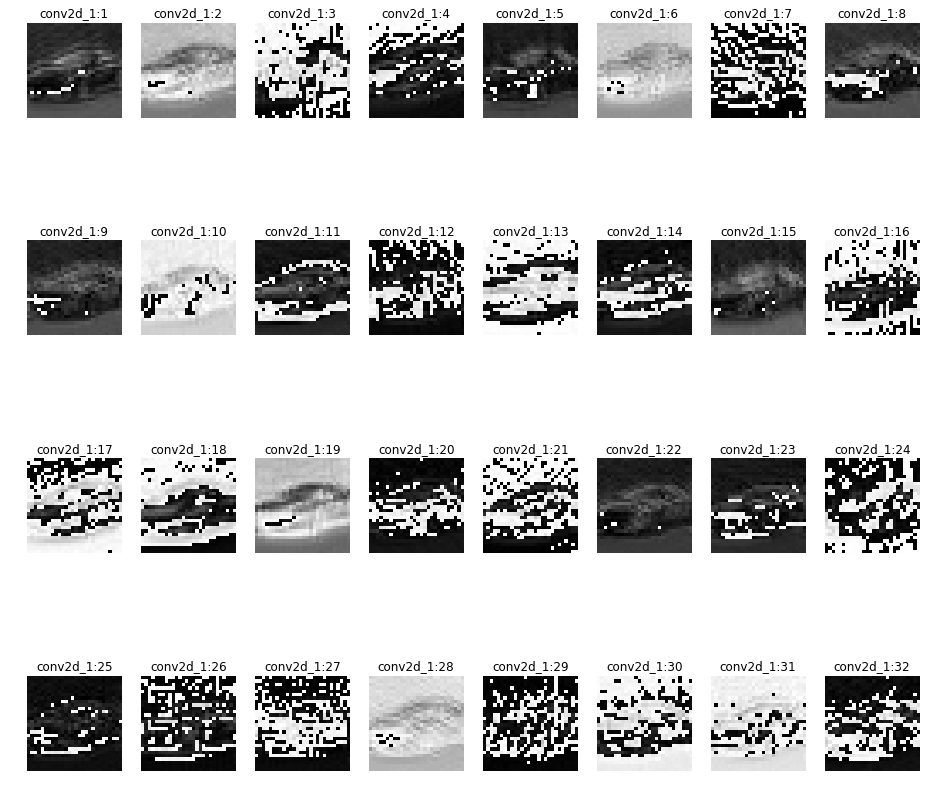

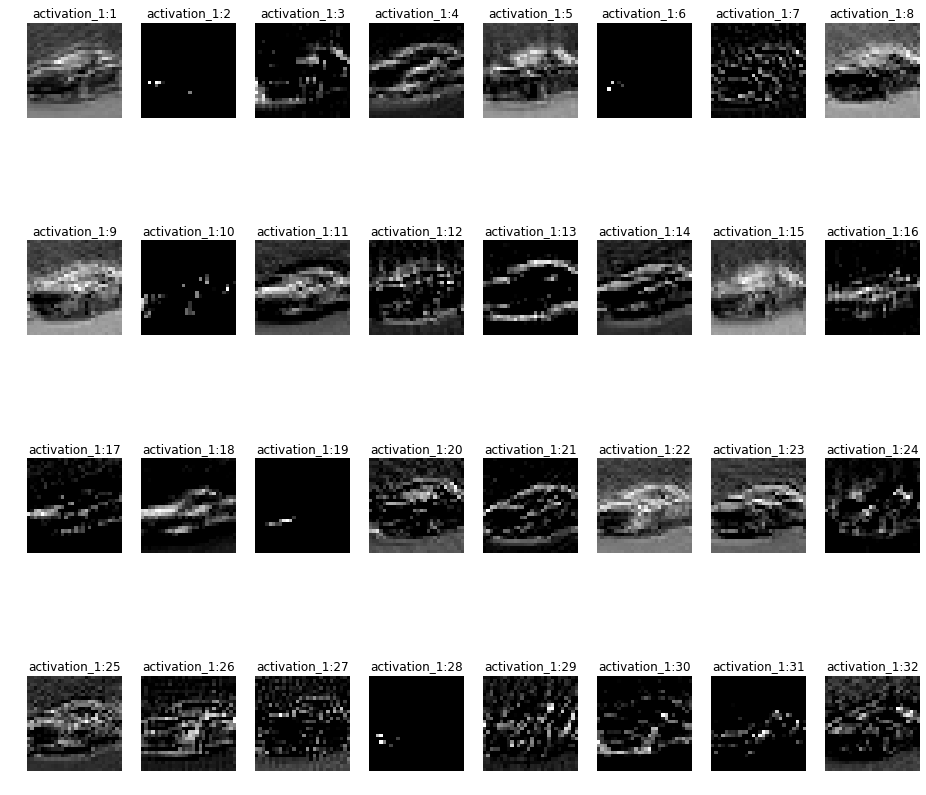

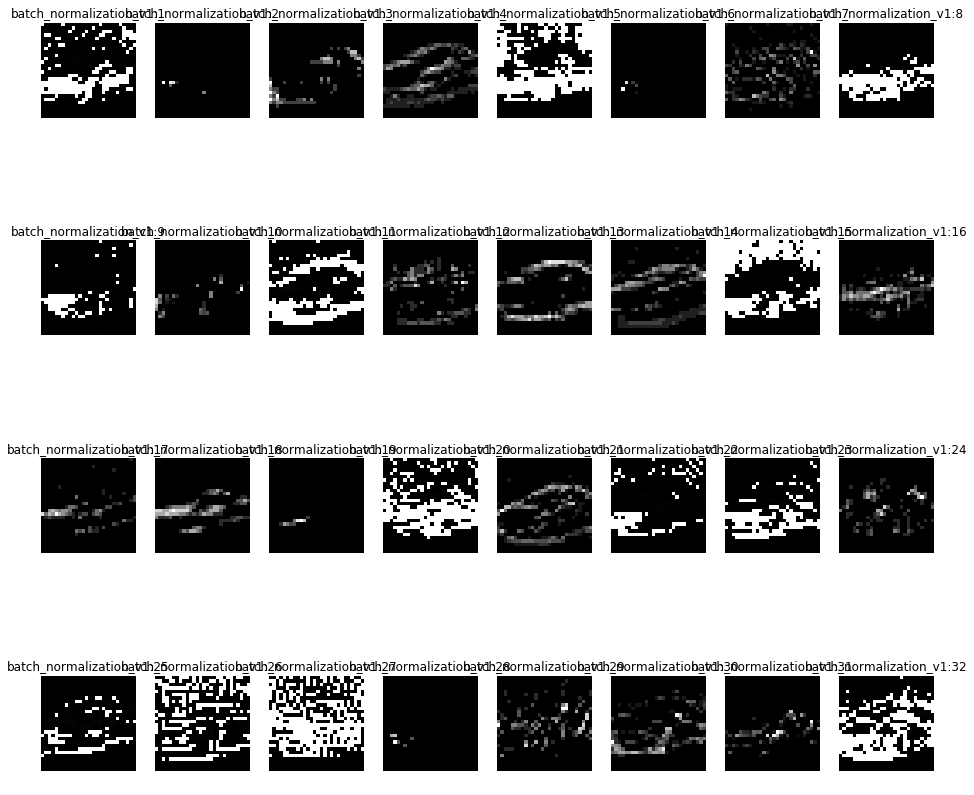

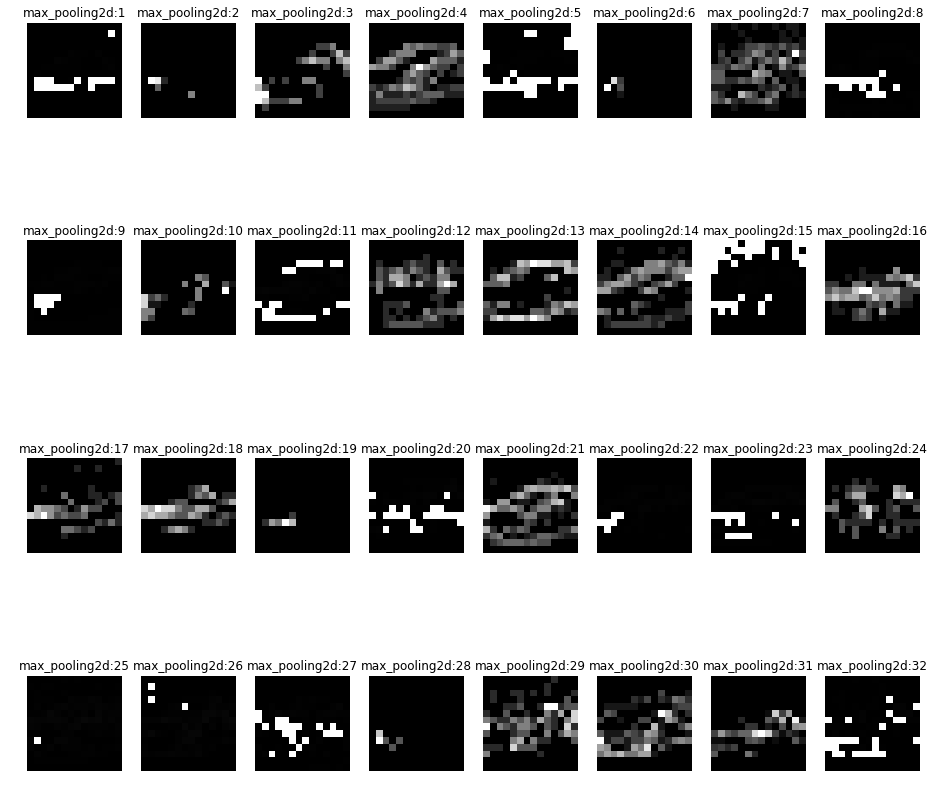

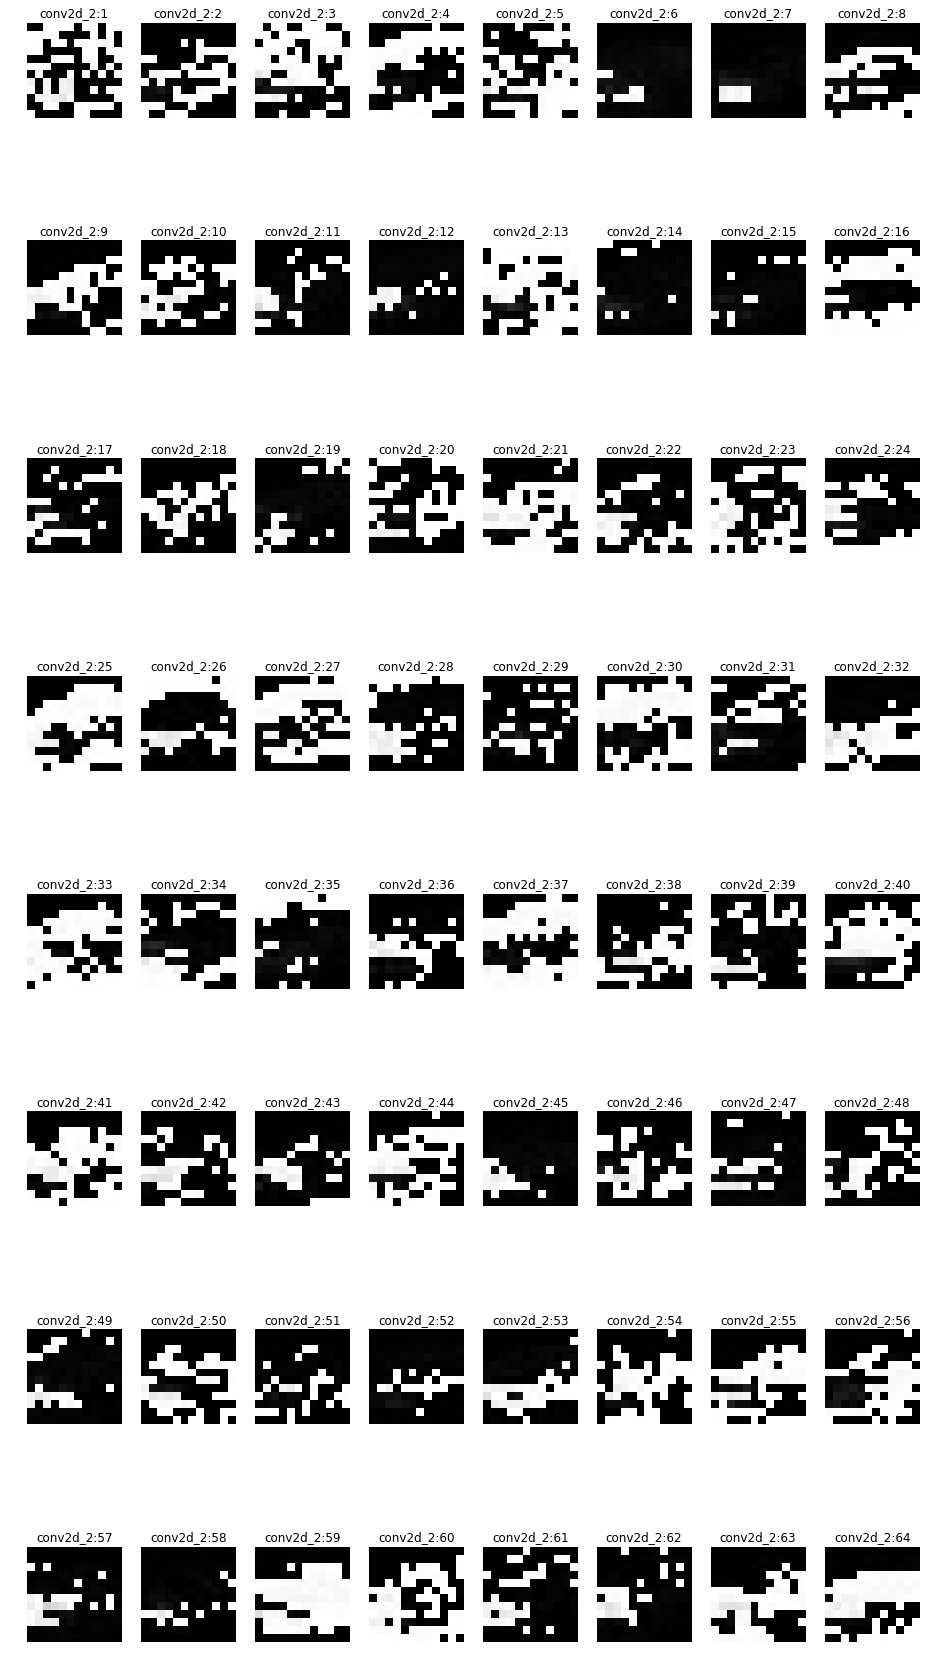

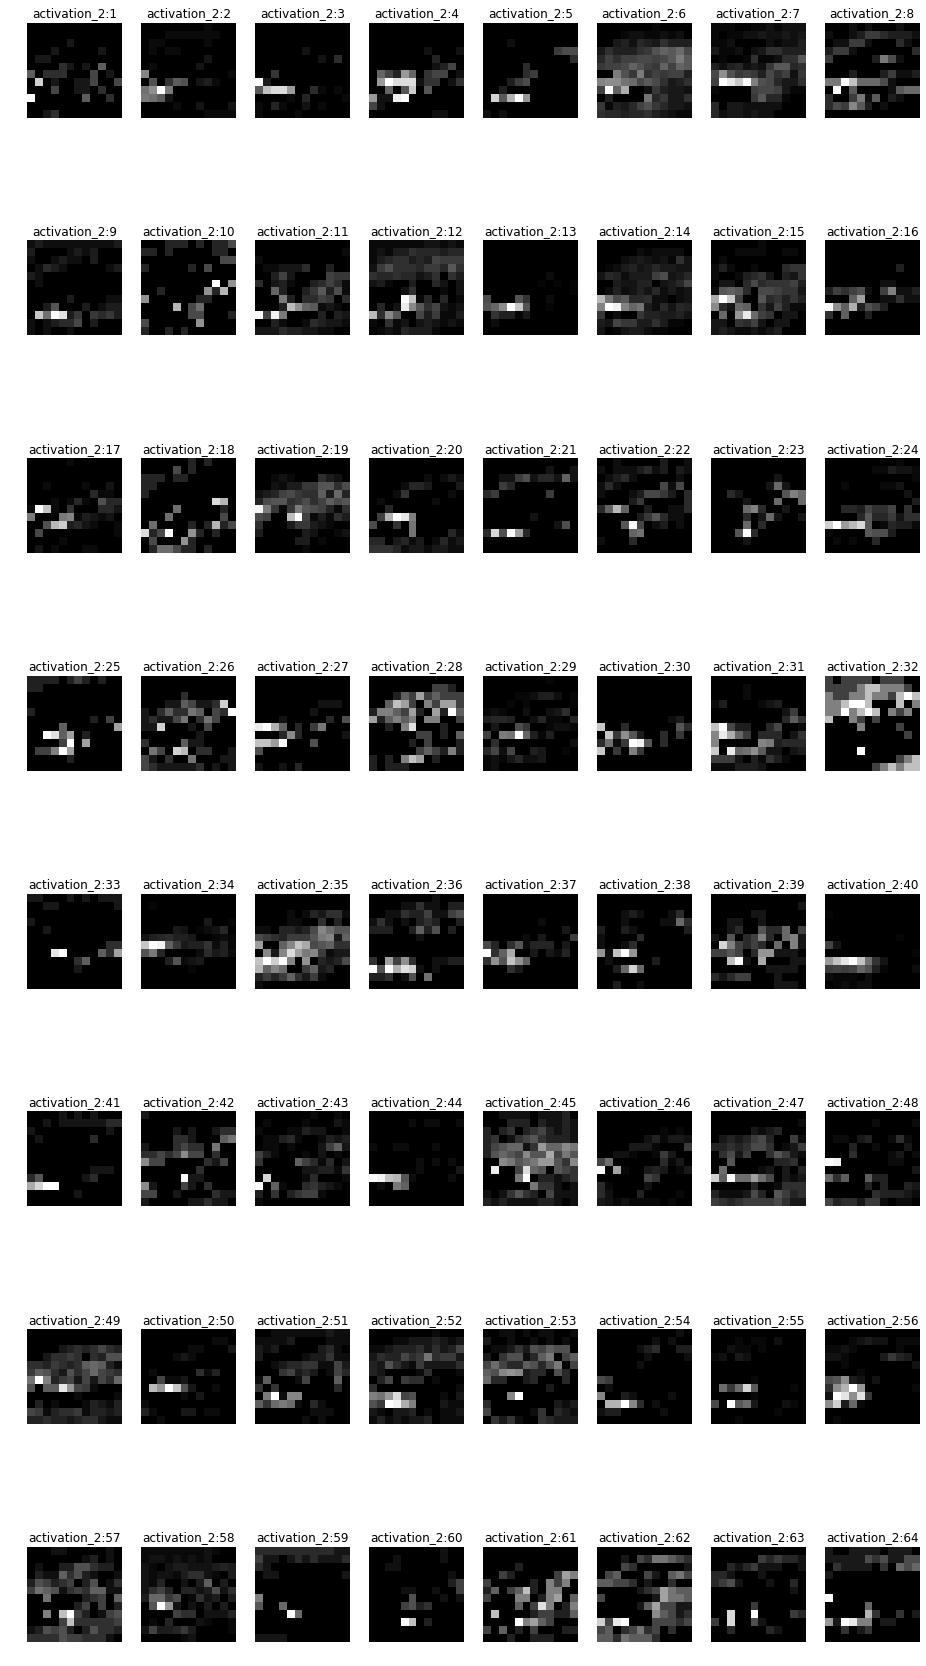

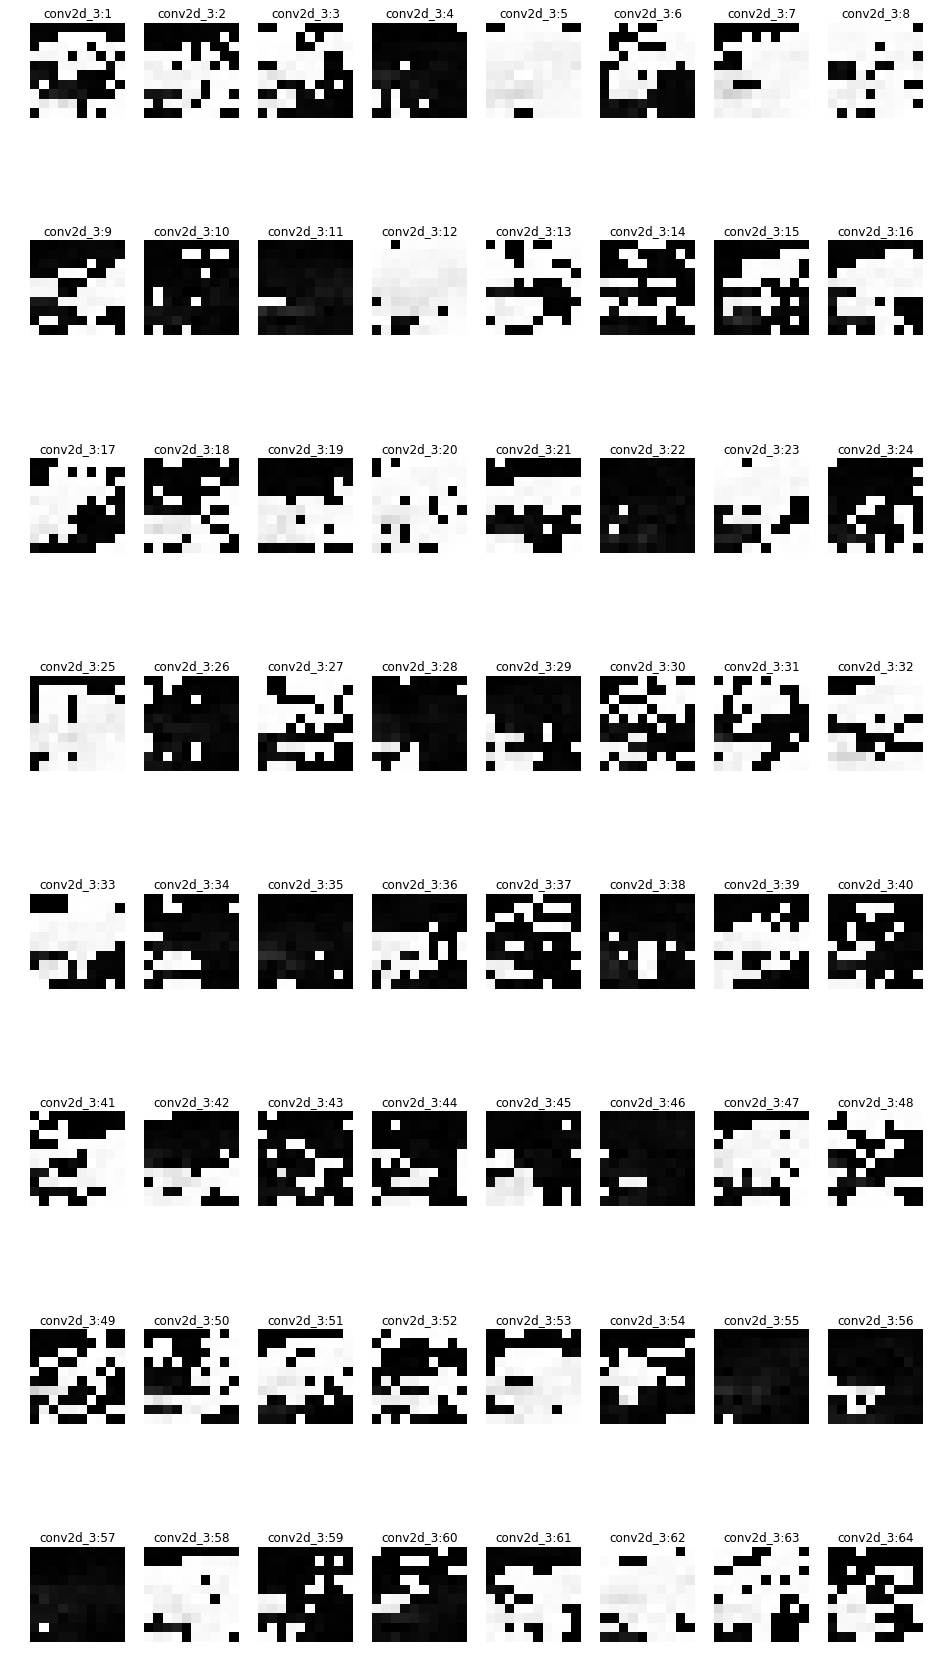

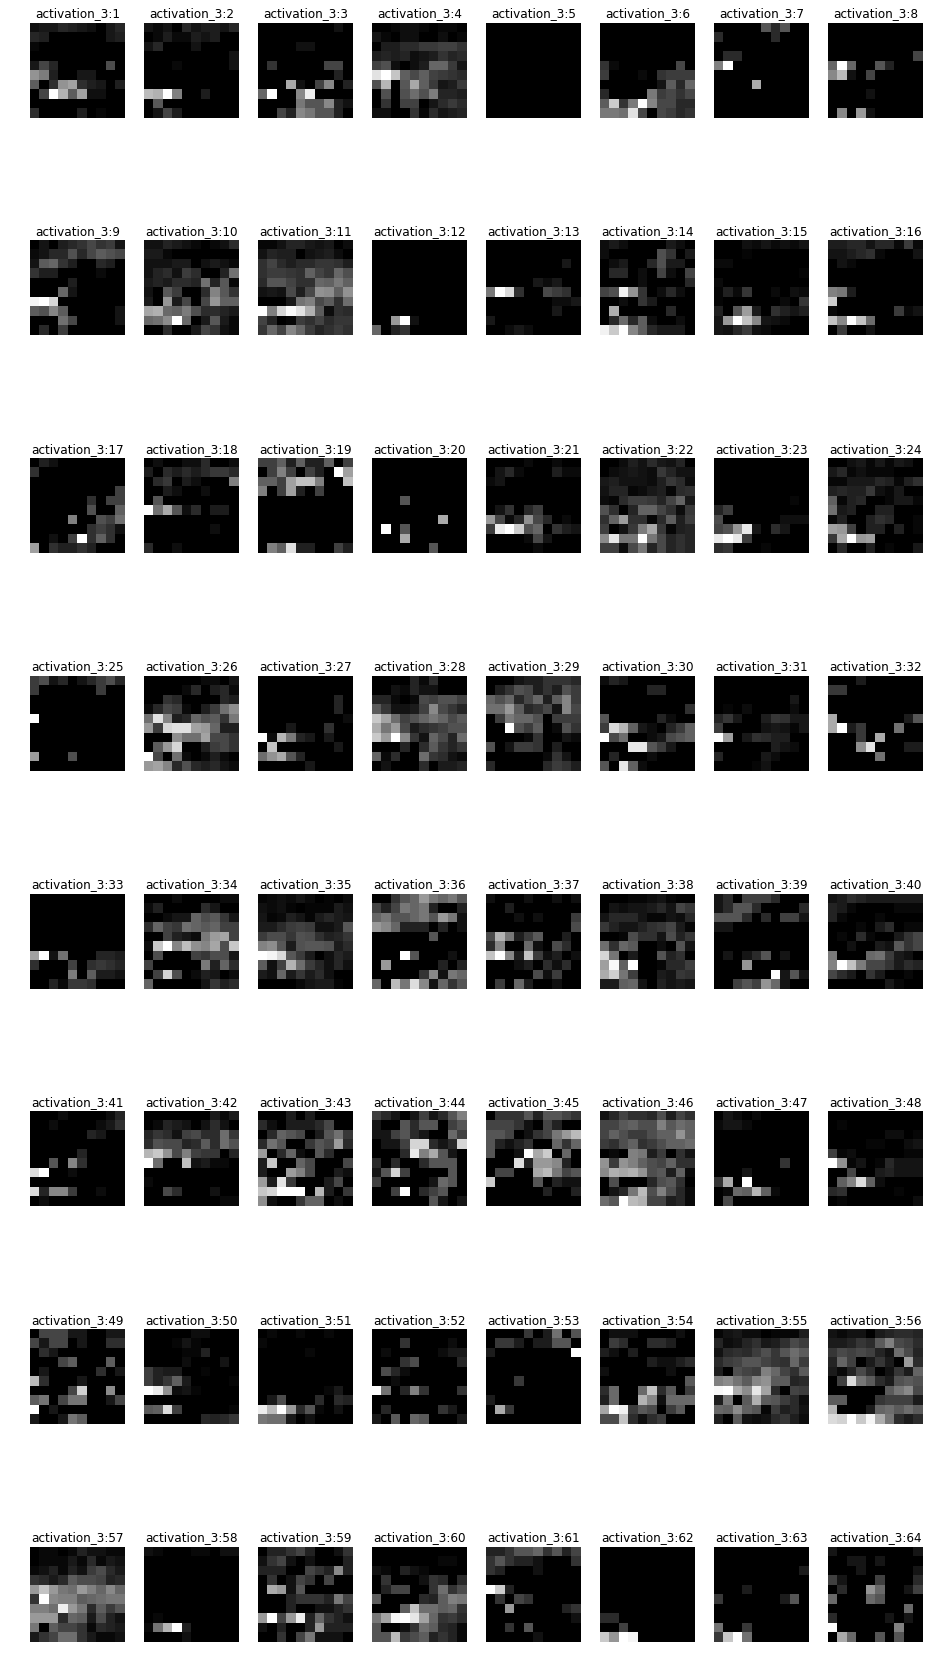

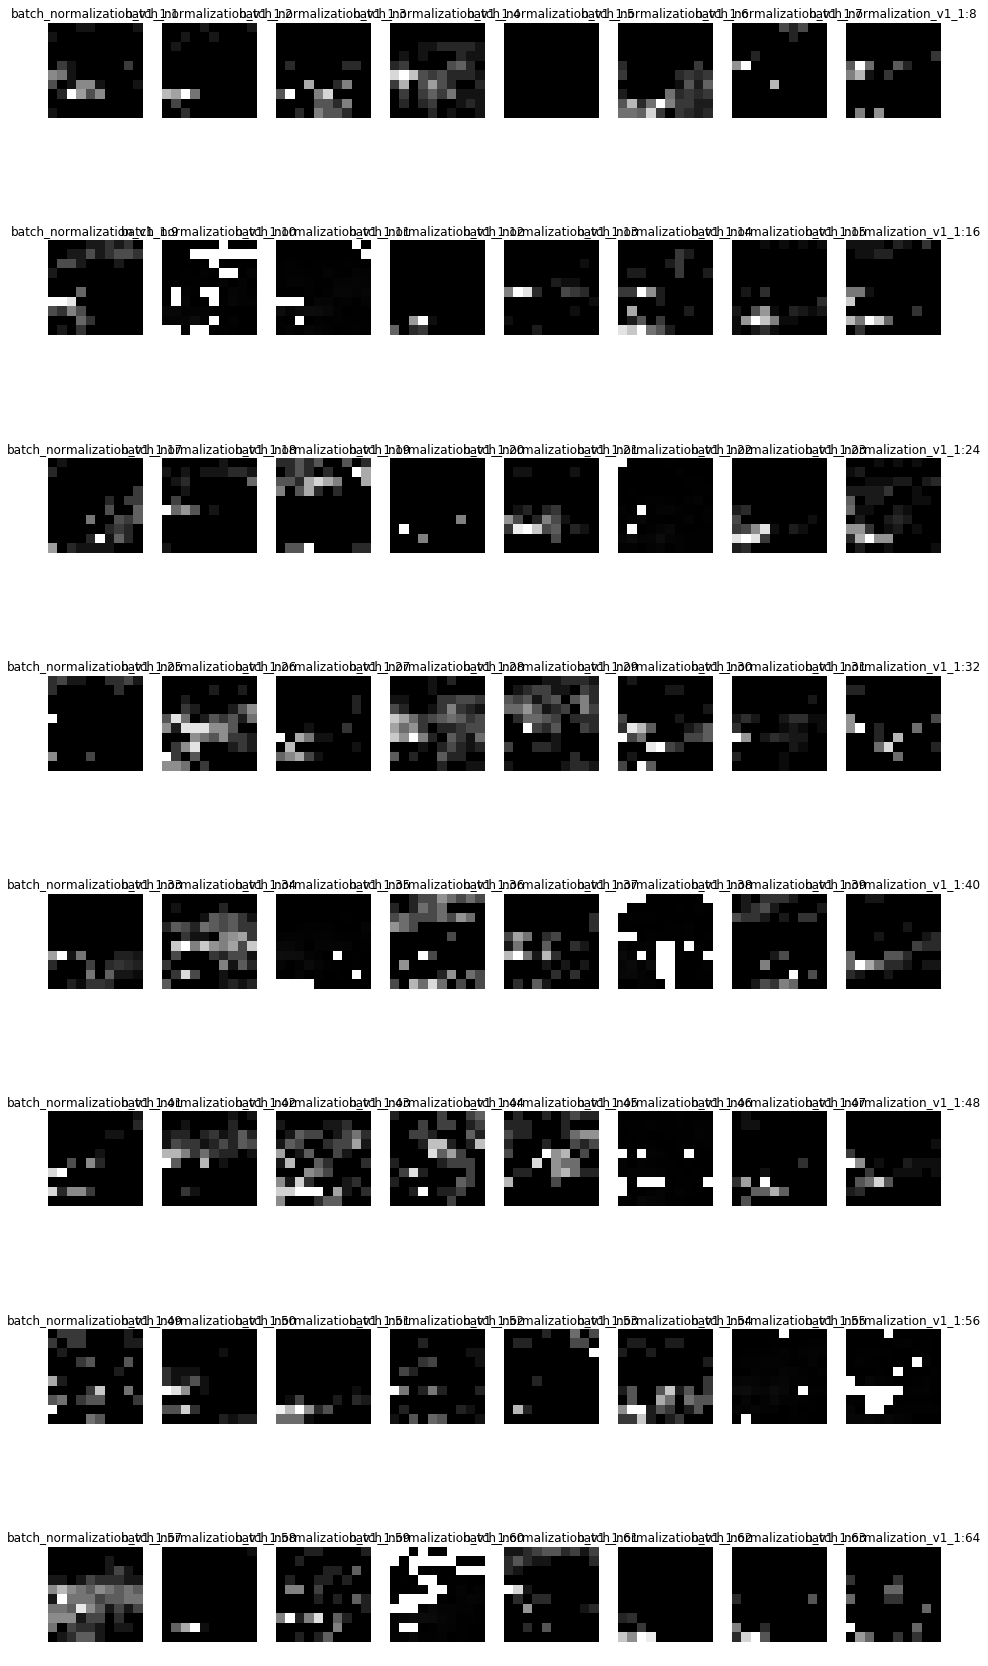

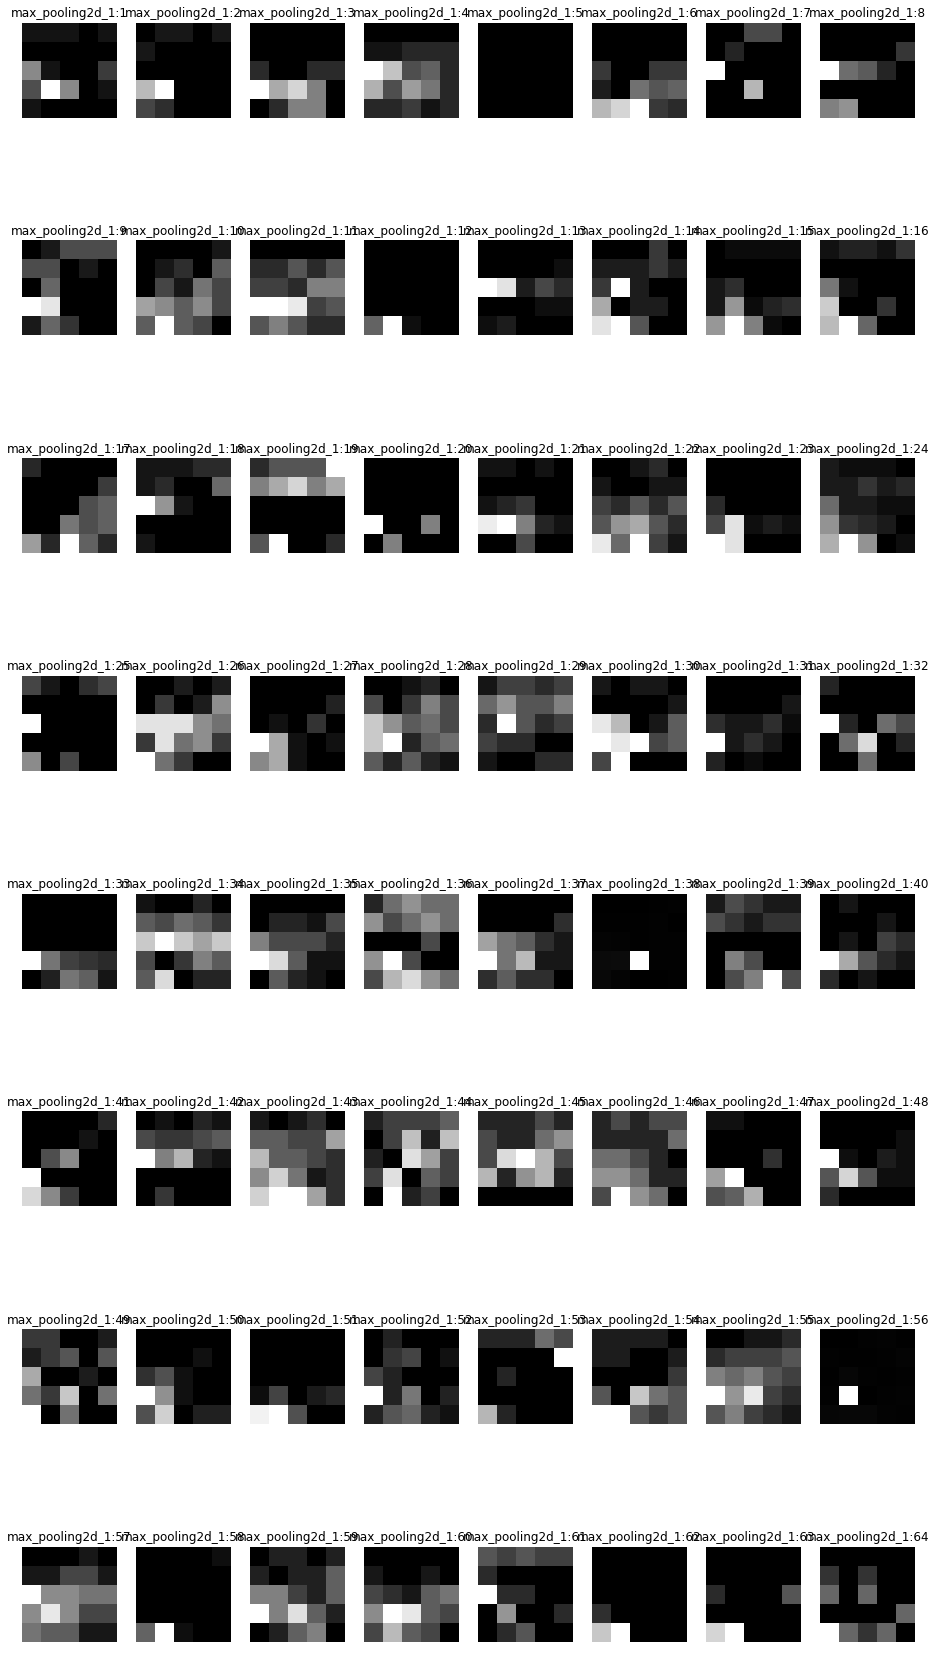

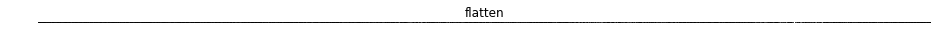

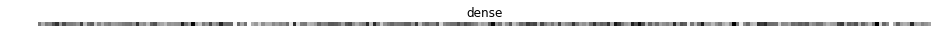

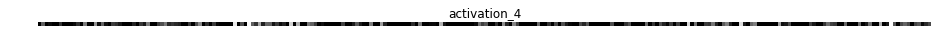

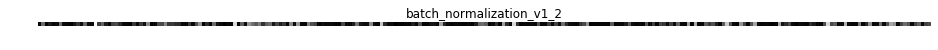

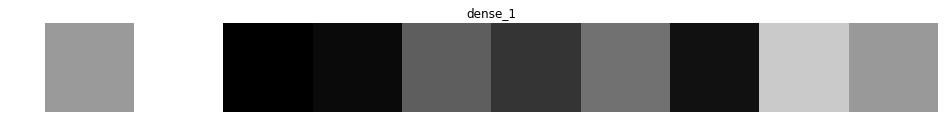

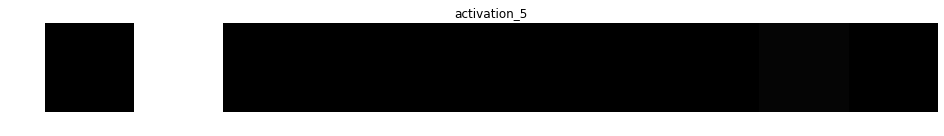

In [25]:
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from PIL import Image

# 中間層の特徴マップを出力する
def middle_layer_output(numlay, INPDATA):
    get_layer = K.function([model.layers[0].input], [model.layers[numlay].output])
    # InputLayerは除外(VGG16転移学習)
    # print(str(model.layers[numlay].__class__.__name__))
    if str(model.layers[numlay].__class__.__name__) == "InputLayer":
        return
    layer_name = model.layers[numlay].name
    layer_output_comp = get_layer([INPDATA])[0]
    if layer_output_comp.ndim == 4:
        dim_n = layer_output_comp.shape[0]
        dim_x = layer_output_comp.shape[1]
        dim_y = layer_output_comp.shape[2]
        dim_z = layer_output_comp.shape[3]
    else:
        dim_n = layer_output_comp.shape[0]
        dim_z = layer_output_comp.shape[1]

    #中間層の出力を図化する
    plt.figure(figsize=(16,512))
    for num_pic in range(dim_n):
        if layer_output_comp.ndim == 4:
            for num_map in range(dim_z):
                img = layer_output_comp[num_pic, :, :, num_map]
                img = Image.fromarray(np.uint8(img))
                plt.subplot(128,8,num_map+1)
                plt.axis('off')
                plt.title(str(layer_name+':'+str(num_map+1)))
                plt.imshow(img, cmap='gray')
#                plt.imshow(img)
    
        else:
            dims = int(len(layer_output_comp[0]))
            img = layer_output_comp[num_pic, :]
            img = img.reshape(1,dims).astype(np.float32)
            plt.axis('off')
            plt.title(str(layer_name))
            plt.imshow(img, cmap='gray')
#            plt.imshow(img)

# レイヤーごとの特徴マップの出力
for layers in range(len(model.layers)):
    middle_layer_output(layers, img)

CNNでは、画像の形式で扱っているので、ConvolutionおよびMaxPoolingにおいてはINPUT画像の変化が見て取れます。

直感的に理解できるものではありませんが、特徴量をどのように捉え推論しているか、理解の一助にはなるかと思います。

なお、Deep Learningモデルにおいては、INPUTに対する最終的なOUTPUTだけでなく、中間層のOUTPUTを自由に取得することができるという点も非常に重要な特性であることは覚えておいてください。

また、OUTPUTの観点だけでなく、INPUTも同様で、中間層にINPUTし、OUTPUTを得ることもできます。

シーケンシャルなモデル構造でなく、複雑なモデルを構築していくにあたって重要な特性です。


参考までに、jupyter notebook上でモデル構造など可視化させてきましたが、TensorBoardでもどのように見えるのか試してみましょう。

Google Colabでは、直接HTTPアクセスはできないので、ngrokを用いて参照させます。

下記コード実行後し、出力されるURLにアクセスしてみましょう。

In [26]:
# Web参照のため、ngrokを利用
if not os.path.exists('./ngrok'):
    !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
    !unzip ngrok-stable-linux-amd64.zip

# TensorBoardおよびngrokの起動
import subprocess
cmd = "tensorboard --logdir=./logs --host 0.0.0.0 --port 6006 &"
proc_tb = subprocess.call(cmd, shell=True)

cmd = "./ngrok http 6006 &"
proc_ng = subprocess.call(cmd, shell=True)

# TensorBoard URL
!curl -s http://localhost:4040/api/tunnels | python -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2019-06-19 08:49:46--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.45.248.244, 52.86.186.182, 52.55.191.55, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.45.248.244|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16648024 (16M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  15.88M  42.1MB/s    in 0.4s    

2019-06-19 08:49:47 (42.1 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [16648024/16648024]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://8fd71906.ngrok.io


In [0]:
# TensorBoardプロセスの停止
#!ps -ef | grep tensorboard | grep -v grep | awk '{print "kill -9",$2}'| sh

# ngrokプロセスの停止
#!ps -ef | grep ngrok | grep -v grep | awk '{print "kill -9",$2}'| sh
!mkdir model

### 1.2.7 モデルのファイル出力

学習させたモデルを出力し、静的学習済みモデルとして外部で活用することもできます。

ここでは、活用の汎用性を考えてTensorFlowのプロトコルバッファ形式にて出力してみます。

静的学習済みモデルは、プログラムで読み込んで使うことも、GraphPipeやTensorFlow Serving等のモデルサーバーを用いてAPI化して利用することもできます。

Google ColabではDockerを扱うことができないので、ローカルPCやクラウド環境等で試してみてください。

In [28]:
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from tensorflow import identity

# 学習セッションからグラフを復元
ksess = K.get_session()
graph = ksess.graph
kgraph = graph.as_graph_def()

# Outputノード名を取得
num_output = 1
prefix = "output"
pred = [None]*num_output
outputName = [None]*num_output
for i in range(num_output):
    outputName[i] = prefix + str(i)
    pred[i] = identity(model.get_output_at(i), name=outputName[i])
print('output name: ', outputName)

# 変数を定数に変換
constant_graph = graph_util.convert_variables_to_constants(ksess, ksess.graph.as_graph_def(), outputName)

output_dir = model_dir
output_graph_name = f"{model_structure}_{data_set}_{epochs}_frozen_graph.pb"

# 静的学習済みモデルを出力
graph_io.write_graph(constant_graph, output_dir, output_graph_name, as_text=False)


output name:  ['output0']
Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 24 variables.
INFO:tensorflow:Converted 24 variables to const ops.


'/content/drive/My Drive/Colab Notebooks/ImageClassification/model/CNN_CIFAR10_10_frozen_graph.pb'